In [1]:
import os
import glob
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [13]:
#Choose output data to process
run = 'fx02'
years = np.arange(1850,1852)

#Some constants
rho = 1000
months = np.arange(1,13)

#Prepare diagnostic variables
SF   = np.zeros((len(years),len(months)))
EVP  = np.zeros((len(years),len(months)))
CAL  = np.zeros((len(years),len(months)))
RO   = np.zeros((len(years),len(months)))

#Read generic NEMO data
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['O1t0.srf'].values;
ds.close()
ds = xr.open_dataset(f'../data/ecefiles/{run}/{run}_1m_{years[0]}0101_{years[0]}1231_grid_T.nc')
lat = ds['nav_lat'].values
lon = ds['nav_lon'].values
time_bnds = ds['time_centered_bounds']
mask = np.where(lat<-60,1,0)
ds.close()

#Extract diagnostics
for y,yy in enumerate(years):
    ds = xr.open_dataset(f'../data/ecefiles/{run}/{run}_1m_{yy}0101_{yy}1231_grid_T.nc')
    calv = ds['calving'].values
    rnf  = ds['friver'].values
    
    for m,mm in enumerate(months):
        secs = (time_bnds[m,1]-time_bnds[m,0]).values / np.timedelta64(1, 's')
        CAL[y,m] = np.nansum(calv[m,:,:]*area*mask*secs*1e-12)
        RO[y,m]  = np.nansum(rnf[m,:,:]*area*mask*secs*1e-12)
    print(f'{yy}: CAL: {np.sum(CAL[y,:]):.0f} Gt/yr | RO: {np.sum(RO[y,:]):.0f} Gt/yr')
        
#Read generic IFS data
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['A128.srf'].values
ds.close()
ds = xr.load_dataset(f"../data/ecefiles/{run}/ICMGG{run}+{years[0]}01",engine='cfgrib')
lon = ds['longitude'].values
lat = ds['latitude'].values
ds.close()
mask = np.where(lat<-60,1,0)

#Extract diagnostics
for y,yy in enumerate(years):
    for m,mm in enumerate(months):
        fname = f"../data/ecefiles/{run}/ICMGG{run}+{yy}{mm:02d}"
        ds = xr.load_dataset(fname,engine='cfgrib')
        time = ds.time.values
        sf = ds.sf.values
        sd = ds.sd.values
        es = ds.es.values
        ds.close()
        
        SF[y,m]  = np.nansum(sf*np.where(sd>0,1,0)*mask*area*rho*1e-12)
        EVP[y,m] = np.nansum(es*np.where(sd>0,1,0)*mask*area*rho*1e-12)
    print(f'{yy}:  SF: {np.sum(SF[y,:]):.0f} Gt/yr | EVP: {np.sum(EVP[y,:]):.0f} Gt/yr')

1850: CAL: 3126 Gt/yr | RO: 332 Gt/yr
1851: CAL: 3129 Gt/yr | RO: 331 Gt/yr


Ignoring index file '/Users/erwin/projects/KPZ/data/ecefiles/fx02/ICMGGfx02+185012.923a8.idx' older than GRIB file


1850:  SF: 3651 Gt/yr | EVP: -246 Gt/yr
1851:  SF: 3198 Gt/yr | EVP: -281 Gt/yr


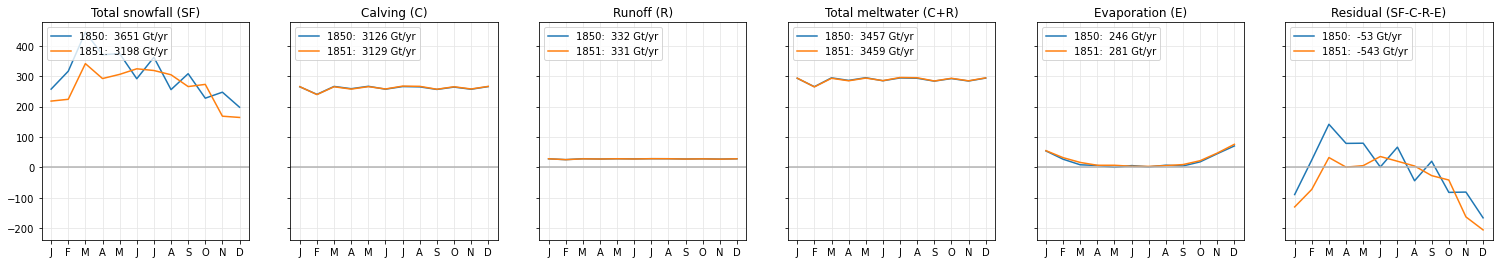

In [19]:
#Merge diagnostics into single variable
var = {}
var[0] = SF
var[1] = CAL
var[2] = RO
var[3] = CAL+RO
var[4] = -EVP
var[5] = SF+EVP-CAL-RO

title = ['Total snowfall (SF)','Calving (C)','Runoff (R)','Total meltwater (C+R)','Evaporation (E)','Residual (SF-C-R-E)']

fig,ax = plt.subplots(1,6,figsize=(26,4),sharey=True)

for v in range(6):
    for y,yy in enumerate(years):
        ax[v].plot(var[v][y,:],label=f'{yy}:  {np.sum(var[v][y,:]):.0f} Gt/yr')
    ax[v].set_title(title[v])
    ax[v].set_xticks(np.arange(12));
    ax[v].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D']);
    ax[v].legend(loc='upper left')
    ax[v].grid(True,color='.9')
    ax[v].axhline(0,0,1,color='.7')
    
plt.savefig(f'../figures/snowfall_new.png',dpi=450)
plt.show()

In [15]:
for v in range(6):
    print(f"{title[v]:20}: {np.mean(np.sum(var[v],axis=1)):4.0f} ({np.std(np.sum(var[v],axis=1)):3.0f}) Gt/yr")

Total snowfall      : 3424 (227) Gt/yr
Calving             : 3127 (  2) Gt/yr
Runoff              :  331 (  1) Gt/yr
Total meltwater (C+R): 3458 (  1) Gt/yr
Evaporation         :  264 ( 18) Gt/yr
Residual (SF-C-R-E) : -298 (245) Gt/yr


In [18]:
print(1.1e8*(365*24*3600)*1e-12)

3468.96
